In [1]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import pm4py.objects.conversion.log
from pm4py.objects.conversion.log import converter
from pm4py.objects.log.util import dataframe_utils
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import re

data_path = Path('../data/')
DD = 'domestic_declarations'
ID = 'international_declarations'
PT = 'prepaid_travel_costs'
RP = 'request_for_payment'
TP = 'travel_permit'

datasets = [DD, ID, PT, RP, TP]
datasets = [data_path / x for x in datasets]  


'''further funcs supposed to be class methods in future versions'''


def atoi_like(s, option='first'):
    """parser of ANY numeric data from str ones; output is in str format"""
    
    try:
        num_str = s.strip()
        num_str = re.findall(r"[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", num_str)
        if option == 'all': return num_str 
        else: return num_str[0]  # functional can be upgraded later
    except (IndexError, TypeError, ValueError, AttributeError): return s
    
    
'''!!!COPYPASTED CHECK IT LATER!!!'''
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
'''!!!COPYPASTED CHECK IT LATER!!!'''

    
def xes_event_logs():
    """pulls .xes files from dirs and saves to pm4py Event_log; saves in var logs"""
    
    try:
        data = globals()['logs']
    except KeyError:
        data = dict()
        for _dir in datasets:
            for dataset in _dir.iterdir():
                data[str(_dir.relative_to(data_path))] = xes_importer.apply(str(dataset)) if\
                    str(dataset).endswith('xes') else data.get(str(_dir.relative_to(data_path)));
    
    return data


def xes2dataframe(xes_file, configuration='convenient', sortby=False, gmt_time=True):  # needs to be simpler one
    """represents .xes file as pandas dataframe with opportunity of exporting options choice;
    implemented for performance achievment either;  
    it's not recommended to use 'sortby' option with 'default' mode;
    does job from scratch"""
    
    variant = converter.Variants.TO_DATA_FRAME
    params = {variant.value.Parameters.DEEP_COPY: True}  # can be reconsidered
    print(f'converting event log {xes_file} to dataframe')
    try:
        xes_file = globals()['logs'][xes_file]
    except KeyError:
        print('accesing ".xes" data failed. xes_event_logs must be invoked')
        return
    
    dataframe = converter.apply(xes_file,\
                variant=variant, parameters=params)  # just conversion
    
    '''tuning section start'''
    if configuration == 'convenient':
        print('applying cosmetic changes')
        dataframe.rename(columns={name: name.replace(':', '_') for name in dataframe.columns}, inplace=True) # just formatting
        dataframe = dataframe_utils.convert_timestamp_columns_in_df(dataframe) if gmt_time else dataframe # gmt time
        for col in dataframe.columns: 
            dataframe[col] = dataframe[col].apply(lambda x: atoi_like(x))  # removing extraneous data before declaration number
        
        try:  # FIXME it's not normal behaviour; 5th fails
            num_fields = dataframe.select_dtypes(include=['int', 'float'])  # casting numeric fields to uint32 for performance objective
            num_fields = num_fields.astype('uint32')
            dataframe[num_fields.columns] = num_fields
        except ValueError:
            pass
        
        obj_fields = dataframe.select_dtypes(include=['object']).copy()
        for col in obj_fields.columns:  # categorizing object fields for performance objective
            num_unique_values, num_total_values = len(obj_fields[col].unique()), len(obj_fields[col])
            obj_fields.loc[:,col] = obj_fields[col].astype('category') if num_unique_values\
            / num_total_values < 0.8 else obj_fields[col]  # random threshhold; find better if u want
        dataframe[obj_fields.columns] = obj_fields
        
        if not sortby:
            pass
        else:
            dataframe = dataframe.sort_values(sortby)  # sorting by column parameter
        '''tuning section end'''
    
    elif configuration == 'default':
        print('proceeding with standard pm4py event <-> df conversion')
        
    return dataframe

    
def all_dataframes(configuration='convenient'):
    """gets all dataframes at once and saves in var all_dfs"""
        
    try:  # FIXME 
        df_dict = globals()['all_dfs']
        xes_files = globals()['logs']
        for _ in tqdm(iter(xes_files.keys()), ascii=True,\
                      desc=f'TRAVERSING FOLLOWING LOGS IN DICT OF DATAFRAMES:\n{_}'):
                df_dict[_] = xes2dataframe(_, configuration=configuration) if df_dict[_] is None else df_dict[_];
                print('MEM consume:', mem_usage(df_dict[_]))

    except:
        df_dict = dict()
        xes_event_logs()
        all_dataframes()
        
    return df_dict

In [2]:
logs = xes_event_logs()

In [3]:
logs[list(logs.keys())[1]][0][0]  # i. e. of usage

{'id': 'rv_travel permit 76455_6', 'org:resource': 'STAFF MEMBER', 'concept:name': 'Start trip', 'time:timestamp': datetime.datetime(2016, 10, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'org:role': 'EMPLOYEE'}

__kostylb INITIATED__

In [4]:
# kostylb unfot  'to_drop'
%run df_4_drop.py

In [5]:
names = [DD, ID, PT, RP, TP]
all_dfs = {name: None for name in names}
all_dfs['travel_permit'] = xes2dataframe(tuple(logs.keys())[4]).drop(to_drop, axis=1)
# all_dfs['travel_permit'] 

converting event log travel_permit to dataframe
applying cosmetic changes


__kostylb TERMINATED__

In [6]:
for _ in names[:-1]:
    all_dfs[_] = xes2dataframe(_)

converting event log domestic_declarations to dataframe
applying cosmetic changes
converting event log international_declarations to dataframe
applying cosmetic changes
converting event log prepaid_travel_costs to dataframe
applying cosmetic changes
converting event log request_for_payment to dataframe
applying cosmetic changes


#### do not run this cells yet

In [ ]:
n = 4                                      # which_dataset_number
df = xes2dataframe(tuple(logs.keys())[n])  # !TODO wrap it up in ipywidget 'list'

In [28]:
''' 0: 7.36 MB
    1: 14.02 MB
    2: 3.24 MB
    3: 5.48 MB
    4: 13.19 MB
''';
mem_usage(df)

'13.19 MB'

In [ ]:
all_dfs = all_dataframes()  # can potentially cause kernel death

#### these are to run 

In [97]:
# names = [DD, ID, PT, RP, TP]
display(all_dfs[DD].head(1)), display(all_dfs[DD].shape)

,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,86794,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 08:49:50+00:00,EMPLOYEE,86791,86791,86566,86792,26


(56437, 10)

(None, None)

In [102]:
all_dfs[DD].shape, all_dfs[ID].shape, all_dfs[PT].shape, all_dfs[RP].shape, all_dfs[TP].shape

((56437, 10), (72151, 23), (18246, 22), (36796, 14), (86581, 21))

In [99]:
gb = curr_df.groupby('id', as_index=False, sort=True)
gb.count()[['time_timestamp', 'id']]
# gb.count()[['case_BudgetNumber', 'id']].hist()

,time_timestamp,id
0,2,1000
1,1,10000
2,1,10001
3,1,10002
4,1,10003
...,...,...
69668,2,9993
69669,2,9995
69670,1,9997
69671,1,9998


In [59]:
curr_df.case_BudgetNumber.value_counts()

922      3476
698      3061
635      3054
6198     2419
475      2377
         ... 
24796       6
23914       6
43926       6
18408       5
65107       3
Name: case_BudgetNumber, Length: 226, dtype: int64

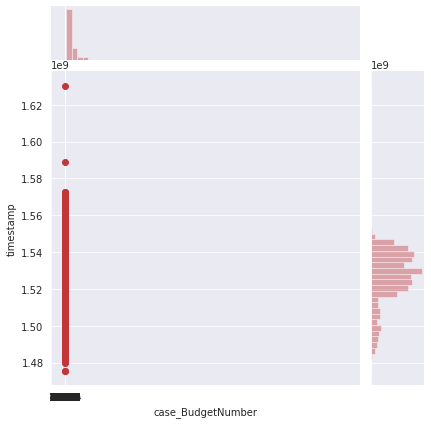

In [87]:
import seaborn as sns; sns.set_style('darkgrid'); sns.set_palette('RdBu')
import matplotlib.pyplot as plt

# curr_df['timestamp'] = curr_df.time_timestamp.apply(lambda x: x.timestamp())
# sns.jointplot(x='case_BudgetNumber', y='timestamp', data=curr_df);
# sns.boxplot(y='case_RequestedBudget', data=curr_df);


# fig = plt.figure()
# 
# ax1 = fig.add_subplot(1,2,1)
# ax1.plot(.cumsum(), 'k-')

# same as before
# ax2 = fig.add_subplot(1,2,2)           # this indicates color and line style
# ax2.plot(np.random.randn(50).cumsum(), 'r-')

!NOTE: be careful with 'id' float conv. FIXME

In [15]:
df.corr()  # numeric corr

,case:TotalDeclared,case:Overspent,case:RequestedBudget,case:OverspentAmount,case:Cost Type_1,case:Cost Type_0,case:Cost Type_3,case:Cost Type_2,case:Cost Type_7,case:Cost Type_6,case:Cost Type_9,case:Cost Type_8,case:Cost Type_5,case:Cost Type_4,case:Cost Type_13,case:Cost Type_14,case:Cost Type_10,case:Cost Type_11,case:Cost Type_12
case:TotalDeclared,1.000000,0.037617,0.044847,0.998278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Overspent,0.037617,1.000000,0.010762,0.042257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:RequestedBudget,0.044847,0.010762,1.000000,-0.005014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:OverspentAmount,0.998278,0.042257,-0.005014,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case:Cost Type_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for i in range(12):
    print(df[f'case:DeclarationNumber_{i+1}'].value_counts())
df.shape

UNKNOWN                     1429
declaration number 73567      90
declaration number 53349      75
declaration number 32582      61
declaration number 45623      53
                            ... 
declaration number 80690      11
declaration number 82739      11
declaration number 11192      11
declaration number 83935      10
declaration number 76003       9
Name: case:DeclarationNumber_1, Length: 912, dtype: int64
UNKNOWN                     740
declaration number 73569     90
declaration number 53351     75
declaration number 32584     61
declaration number 45625     53
                           ... 
declaration number 78111     16
declaration number 85569     16
declaration number 16520     16
declaration number 77288     15
declaration number 83429     14
Name: case:DeclarationNumber_2, Length: 275, dtype: int64
UNKNOWN                     560
declaration number 73571     90
declaration number 53353     75
declaration number 32586     61
declaration number 45627     53
         

(86581, 173)

In [45]:
hypo_data = df_hypo.groupby(by=df_hypo.index).mean().fillna(0).values
np.unique(hypo_data)  # 150 columns of nothing

array([0.])

In [174]:
df_obj = df.select_dtypes(include=['object']).copy()  # to show do df cast with 'default'
df_obj.describe()

ValueError: Cannot describe a DataFrame without columns

In [151]:
cat = df_obj.org_resource.astype('category')
print('AMOUNT:\t', cat.unique().shape, '\n', cat.unique())

AMOUNT:	 (2,) 
 [STAFF MEMBER, SYSTEM]
Categories (2, object): [STAFF MEMBER, SYSTEM]


In [162]:
print(mem_usage(cat), mem_usage(df_obj.org_resource))  # not bad

0.07 MB 4.67 MB


In [173]:
df_obj = df.select_dtypes(include=['object']).copy()
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.8:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]
        
        
print(mem_usage(df_obj))
print(mem_usage(converted_obj))

0.00 MB
0.00 MB


In [161]:
df[converted_obj.columns] = converted_obj
mem_usage(df)

'14.02 MB'

In [148]:
cat = df_obj.org_role.astype('category')
print('AMOUNT:\t', cat.unique().shape, '\n', cat.unique())

AMOUNT:	 (8,) 
 [EMPLOYEE, SUPERVISOR, UNDEFINED, DIRECTOR, PRE_APPROVER, ADMINISTRATION, MISSING, BUDGET OWNER]
Categories (8, object): [EMPLOYEE, SUPERVISOR, UNDEFINED, DIRECTOR, PRE_APPROVER, ADMINISTRATION, MISSING, BUDGET OWNER]


In [144]:
cat = df_obj.concept_name.astype('category');
print('AMOUNT:\t', cat.unique().shape, '\n', cat.unique())

AMOUNT:	 (34,) 
 [Start trip, End trip, Permit SUBMITTED by EMPLOYEE, Permit FINAL_APPROVED by SUPERVISOR, Declaration SUBMITTED by EMPLOYEE, ..., Permit APPROVED by BUDGET OWNER, Permit REJECTED by ADMINISTRATION, Declaration REJECTED by BUDGET OWNER, Permit REJECTED by BUDGET OWNER, Permit REJECTED by DIRECTOR]
Length: 34
Categories (34, object): [Start trip, End trip, Permit SUBMITTED by EMPLOYEE, Permit FINAL_APPROVED by SUPERVISOR, ..., Permit REJECTED by ADMINISTRATION, Declaration REJECTED by BUDGET OWNER, Permit REJECTED by BUDGET OWNER, Permit REJECTED by DIRECTOR]


[how to](https://www.dataquest.io/blog/pandas-big-data/) significantly reduce mem usage

BTW remember to fill UNKNOWN e.t.c

In [78]:
# case_id is not the same as DeclarationNumber
df.groupby('case_id', as_index=False)['case_DeclarationNumber'].apply(lambda x: x)

0      12788    declaration number 100001
       12789    declaration number 100001
       12790    declaration number 100001
       12791    declaration number 100001
       12792    declaration number 100001
                          ...            
10499  12756     declaration number 99996
       12757     declaration number 99996
       12758     declaration number 99996
       12759     declaration number 99996
       12760     declaration number 99996
Name: case_DeclarationNumber, Length: 56437, dtype: object

In [136]:
df.head(3)

,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+01:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+01:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+01:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205


In [128]:
# in development
def df_through(column):
    return df[column].apply(lambda x: atoi_like(x))

In [157]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: atoi_like(x))
# what did _digit in id mean? FIXME
df.head(3)

,id,org_resource,concept_name,time_timestamp,org_role,case_id,case_concept_name,case_BudgetNumber,case_DeclarationNumber,case_Amount
0,86794,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+01:00,EMPLOYEE,86791,86791,86566,86792,26.851205
1,86793,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+01:00,SUPERVISOR,86791,86791,86566,86792,26.851205
2,86791,SYSTEM,Request Payment,2017-01-10 09:34:44+01:00,UNDEFINED,86791,86791,86566,86792,26.851205


In [234]:
pd.pivot_table(df, values='concept_name',\
               index='case_id',\
               columns='org_role', fill_value='⚠️',\
               aggfunc=',->'.join)

org_role,ADMINISTRATION,BUDGET OWNER,EMPLOYEE,MISSING,PRE_APPROVER,SUPERVISOR,UNDEFINED
case_id,,,,,,,
100000,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100005,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100010,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100015,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
100021,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
...,...,...,...,...,...,...,...
99973,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
99978,Declaration APPROVED by ADMINISTRATION,⚠️,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"
99983,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration SUBMITTED by EMPLOYEE,⚠️,⚠️,Declaration FINAL_APPROVED by SUPERVISOR,"Request Payment,->Payment Handled"


In [225]:
pd.pivot_table(df, values=['case_Amount', 'concept_name'],\
               index=['case_DeclarationNumber', 'case_id'],\
               columns='org_role', fill_value='⚠️').\
               query('case_id < "90000" and case_id > "89000"')

case_Amount                           \
org_role                       ADMINISTRATION BUDGET OWNER    EMPLOYEE   
case_DeclarationNumber case_id                                           
89005                  89004               ⚠️           ⚠️   71.129552   
89010                  89009               ⚠️           ⚠️  134.457797   
89014                  89013               ⚠️           ⚠️   46.058080   
89018                  89017               ⚠️           ⚠️   49.179209   
89022                  89021               ⚠️           ⚠️   31.469399   
...                                       ...          ...         ...   
UNKNOWN                89820               ⚠️           ⚠️    0.000000   
                       89830               ⚠️           ⚠️    0.000000   
                       89848               ⚠️           ⚠️    0.000000   
                       89887               ⚠️           ⚠️    0.000000   
                       89973               ⚠️           ⚠️    0.000000   

                                                                          
org_role                       MISSING PRE_APPROVER SUPERVISOR UNDEFINED  
case_DeclarationNumber case_id                                            
89005                  89004        ⚠️      71.1296    71.1296   71.1296  
89010                  89009        ⚠️           ⚠️    134.458   134.458  
89014                  89013        ⚠️           ⚠️    46.0581   46.0581  
89018                  89017        ⚠️           ⚠️    49.1792   49.1792  
89022                  89021        ⚠️           ⚠️    31.4694   31.4694  
...                                ...          ...        ...       ...  
UNKNOWN                89820        ⚠️           ⚠️         ⚠️        ⚠️  
                       89830        ⚠️            0          0        ⚠️  
                       89848        ⚠️           ⚠️         ⚠️        ⚠️  
                       89887         0           ⚠️          0        ⚠️  
                       89973        ⚠️            0          0        ⚠️  

[222 rows x 7 columns]

In [209]:
# df.pivot(index='case_id', columns='org_role', values='case_Amount')
# Index contains duplicate entries, cannot reshape
df.pivot_table(index='case_id', columns='org_role', values='case_Amount')..describe()
# in MISSING have 87 not na values with 24 null values
# in UNDEFINED only 453 are na

50.928409     32
52.499349     22
6.360310      21
43.977730     19
31.892582     16
              ..
201.880202     1
10.699429      1
283.618695     1
9.145726       1
34.961227      1
Name: UNDEFINED, Length: 8320, dtype: int64

In [221]:
pd.pivot_table(df, values=['case_Amount', 'concept_name'],\
               index=['case_DeclarationNumber', 'case_id', 'case_BudgetNumber'],\
               columns='org_role',
               aggfunc='first', fill_value='⚠️').\
               query('case_id < "90000" and case_id > "89000"')  # choice of aggfunc and other params isn't evident

case_Amount               \
org_role                                         ADMINISTRATION BUDGET OWNER   
case_DeclarationNumber case_id case_BudgetNumber                               
89005                  89004   86566                         ⚠️           ⚠️   
89010                  89009   86566                         ⚠️           ⚠️   
89014                  89013   86566                         ⚠️           ⚠️   
89018                  89017   86566                         ⚠️           ⚠️   
89022                  89021   86566                         ⚠️           ⚠️   
...                                                         ...          ...   
UNKNOWN                89820   86566                         ⚠️           ⚠️   
                       89830   86566                         ⚠️           ⚠️   
                       89848   86566                         ⚠️           ⚠️   
                       89887   86566                         ⚠️           ⚠️   
                       89973   86566                         ⚠️           ⚠️   

                                                                      \
org_role                                            EMPLOYEE MISSING   
case_DeclarationNumber case_id case_BudgetNumber                       
89005                  89004   86566               71.129552      ⚠️   
89010                  89009   86566              134.457797      ⚠️   
89014                  89013   86566               46.058080      ⚠️   
89018                  89017   86566               49.179209      ⚠️   
89022                  89021   86566               31.469399      ⚠️   
...                                                      ...     ...   
UNKNOWN                89820   86566                0.000000      ⚠️   
                       89830   86566                0.000000      ⚠️   
                       89848   86566                0.000000      ⚠️   
                       89887   86566                0.000000       0   
                       89973   86566                0.000000      ⚠️   

                                                                          \
org_role                                         PRE_APPROVER SUPERVISOR   
case_DeclarationNumber case_id case_BudgetNumber                           
89005                  89004   86566                  71.1296    71.1296   
89010                  89009   86566                       ⚠️    134.458   
89014                  89013   86566                       ⚠️    46.0581   
89018                  89017   86566                       ⚠️    49.1792   
89022                  89021   86566                       ⚠️    31.4694   
...                                                       ...        ...   
UNKNOWN                89820   86566                       ⚠️         ⚠️   
                       89830   86566                        0          0   
                       89848   86566                       ⚠️         ⚠️   
                       89887   86566                       ⚠️          0   
                       89973   86566                        0          0   

                                                             concept_name  \
org_role                                         UNDEFINED ADMINISTRATION   
case_DeclarationNumber case_id case_BudgetNumber                            
89005                  89004   86566               71.1296             ⚠️   
89010                  89009   86566               134.458             ⚠️   
89014                  89013   86566               46.0581             ⚠️   
89018                  89017   86566               49.1792             ⚠️   
89022                  89021   86566               31.4694             ⚠️   
...                                                    ...            ...   
UNKNOWN                89820   86566                    ⚠️             ⚠️   
                       89830   86566                    ⚠️             ⚠️   
          

In [224]:
pd.pivot_table(df, values=['case_Amount', 'concept_name'],\
               index=['case_DeclarationNumber', 'case_id', 'case_BudgetNumber'],\
               columns='org_role',
               aggfunc={'case_Amount': 'last', 'concept_name': ',\n'.join}, fill_value='⚠️').\
               query('case_id < "90000" and case_id > "89000"')  # choice of aggfunc and other params isn't evident

case_Amount               \
org_role                                         ADMINISTRATION BUDGET OWNER   
case_DeclarationNumber case_id case_BudgetNumber                               
89005                  89004   86566                         ⚠️           ⚠️   
89010                  89009   86566                         ⚠️           ⚠️   
89014                  89013   86566                         ⚠️           ⚠️   
89018                  89017   86566                         ⚠️           ⚠️   
89022                  89021   86566                         ⚠️           ⚠️   
...                                                         ...          ...   
UNKNOWN                89820   86566                         ⚠️           ⚠️   
                       89830   86566                         ⚠️           ⚠️   
                       89848   86566                         ⚠️           ⚠️   
                       89887   86566                         ⚠️           ⚠️   
                       89973   86566                         ⚠️           ⚠️   

                                                                      \
org_role                                            EMPLOYEE MISSING   
case_DeclarationNumber case_id case_BudgetNumber                       
89005                  89004   86566               71.129552      ⚠️   
89010                  89009   86566              134.457797      ⚠️   
89014                  89013   86566               46.058080      ⚠️   
89018                  89017   86566               49.179209      ⚠️   
89022                  89021   86566               31.469399      ⚠️   
...                                                      ...     ...   
UNKNOWN                89820   86566                0.000000      ⚠️   
                       89830   86566                0.000000      ⚠️   
                       89848   86566                0.000000      ⚠️   
                       89887   86566                0.000000       0   
                       89973   86566                0.000000      ⚠️   

                                                                          \
org_role                                         PRE_APPROVER SUPERVISOR   
case_DeclarationNumber case_id case_BudgetNumber                           
89005                  89004   86566                  71.1296    71.1296   
89010                  89009   86566                       ⚠️    134.458   
89014                  89013   86566                       ⚠️    46.0581   
89018                  89017   86566                       ⚠️    49.1792   
89022                  89021   86566                       ⚠️    31.4694   
...                                                       ...        ...   
UNKNOWN                89820   86566                       ⚠️         ⚠️   
                       89830   86566                        0          0   
                       89848   86566                       ⚠️         ⚠️   
                       89887   86566                       ⚠️          0   
                       89973   86566                        0          0   

                                                             concept_name  \
org_role                                         UNDEFINED ADMINISTRATION   
case_DeclarationNumber case_id case_BudgetNumber                            
89005                  89004   86566               71.1296             ⚠️   
89010                  89009   86566               134.458             ⚠️   
89014                  89013   86566               46.0581             ⚠️   
89018                  89017   86566               49.1792             ⚠️   
89022                  89021   86566               31.4694             ⚠️   
...                                                    ...            ...   
UNKNOWN                89820   86566                    ⚠️             ⚠️   
                       89830   86566                    ⚠️             ⚠️   
          

### Задача

ДОКЛАД анализ и статистика датасетов

Сергей делает приведение к общему датасету

это про BPI
еще на будущее сделаем и процесс дискавери и реплей

отчет по итогу на английском


Разведывательный анализ данных

начало с 2017 года, там отличия

гипотеза, предположения, по сущностям внутри таблиц

я беру внешнюю табличку

и объясняю гит Насте

чт 16 числа сбор